# Phase 2 — Full Pipeline with Reranking

Independent pipeline that extracts its own memories, builds its own database and test cases,
then runs retrieval experiments with cross-encoder reranking.

Unlike `phase1_reranking_comparison.ipynb` (which reuses Phase 1 data), this notebook
owns its entire pipeline end-to-end, allowing independent prompt/extraction iteration.

In [1]:
# Cell 1 — Setup & Imports
import os
from pathlib import Path

from memory_retrieval.experiments.query_generation import (
    QueryGenerationConfig,
    generate_all_queries,
)
from memory_retrieval.experiments.runner import ExperimentConfig, run_all_experiments
from memory_retrieval.experiments.test_cases import build_test_cases
from memory_retrieval.infra.io import load_json
from memory_retrieval.infra.runs import (
    PHASE2,
    create_run,
    update_run_status,
    get_latest_run,
)
from memory_retrieval.memories.extractor import ExtractionConfig, SituationFormat, extract_memories
from memory_retrieval.search.reranker import Reranker
from memory_retrieval.search.vector import VectorBackend

# Find project root by walking up to pyproject.toml
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "pyproject.toml").exists():
    if PROJECT_ROOT.parent == PROJECT_ROOT:
        raise RuntimeError("Could not find project root (pyproject.toml)")
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

# Verify API key
if not os.environ.get("OPENROUTER_API_KEY"):
    print("WARNING: OPENROUTER_API_KEY is not set. Memory building and query generation will fail.")
else:
    print("OPENROUTER_API_KEY is set.")

print(f"Project root: {PROJECT_ROOT}")
print("Imports OK.")

OPENROUTER_API_KEY is set.
Project root: /Users/mayk/Projects/private/crm-memory-retrieval-research
Imports OK.


In [2]:
# Cell 2 — Configuration

PROMPT_VERSION = "3.0.0"
MODEL_MEMORIES = "anthropic/claude-haiku-4.5"  # LLM for memory extraction
MODEL_EXPERIMENT = "anthropic/claude-sonnet-4.5"  # LLM for query generation

RAW_DATA_DIR = "data/review_data"

# Search & reranking configuration
SEARCH_LIMIT = 20  # Vector search candidates per query
DISTANCE_THRESHOLD = 1.1  # For pre-rerank metrics comparison

# Rerank text strategies: compare reranking on situation-only vs situation+lesson
RERANK_TEXT_STRATEGIES = {
    "situation_only": lambda c: c["situation"],
    "situation_and_lesson": lambda c: f"situation: {c['situation']}; lesson: {c.get('lesson', '')}",
}

# Run selection: use latest run or select a specific one
# To create a new run: RUN_DIR = None (will be created in Step 1)
# To see available runs: print(list_runs(PHASE2))
# To select specific run: RUN_DIR = get_run(PHASE2, "run_20260209_120000")
# RUN_DIR = get_latest_run(PHASE2)
RUN_DIR = None

# Derived paths (automatic from run directory)
if RUN_DIR is not None:
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    QUERIES_DIR = str(RUN_DIR / "queries")
    RESULTS_DIR = str(RUN_DIR / "results")

# Initialize backends
vector_backend = VectorBackend()

print("Configuration:")
print(f"  Using run: {RUN_DIR.name if RUN_DIR else 'None (will create new)'}")
print(f"  Prompt version: {PROMPT_VERSION}")
print(f"  Model (memories): {MODEL_MEMORIES}")
print(f"  Model (experiment): {MODEL_EXPERIMENT}")
print(f"  Search limit: {SEARCH_LIMIT}")
print(f"  Distance threshold: {DISTANCE_THRESHOLD}")
print(f"  Rerank strategies: {list(RERANK_TEXT_STRATEGIES.keys())}")
print(f"  Raw data dir: {RAW_DATA_DIR}")

Configuration:
  Using run: None (will create new)
  Prompt version: 3.0.0
  Model (memories): anthropic/claude-haiku-4.5
  Model (experiment): anthropic/claude-sonnet-4.5
  Search limit: 20
  Distance threshold: 1.1
  Rerank strategies: ['situation_only', 'situation_and_lesson']
  Raw data dir: data/review_data


## Step 1 — Build Memories

Extracts structured memories from raw code review data via LLM.
Each memory contains a **situation description** (25-60 words) and an **actionable lesson** (max 160 chars).

Uses Phase 2 prompts from `data/prompts/phase2`.

Requires `OPENROUTER_API_KEY`.

In [3]:
# Cell 4 — Build Memories: Single File

if RUN_DIR is None:
    run_id, RUN_DIR = create_run(PHASE2)
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    QUERIES_DIR = str(RUN_DIR / "queries")
    RESULTS_DIR = str(RUN_DIR / "results")
    print(f"Created new run: {run_id}")

raw_data_path = Path(RAW_DATA_DIR)
raw_files = sorted(raw_data_path.glob("*.json"))

print(f"Found {len(raw_files)} raw data files:")
for i, f in enumerate(raw_files):
    print(f"  [{i}] {f.name}")

if raw_files:
    target_file = raw_files[0]
    print(f"\nProcessing: {target_file.name}")
    extraction_config = ExtractionConfig(
        situation_format=SituationFormat.SINGLE,
        prompts_dir="data/prompts/phase2",
        prompt_version=PROMPT_VERSION,
        model=MODEL_MEMORIES,
    )
    output_path = extract_memories(
        raw_path=str(target_file),
        out_dir=MEMORIES_DIR,
        config=extraction_config,
    )
    print(f"Output saved to: {output_path}")
else:
    print("No raw data files found.")

Created new run: run_20260214_123725
Found 11 raw data files:
  [0] review_1.json
  [1] review_10.json
  [2] review_11.json
  [3] review_2.json
  [4] review_3.json
  [5] review_4.json
  [6] review_5.json
  [7] review_6.json
  [8] review_7.json
  [9] review_8.json
  [10] review_9.json

Processing: review_1.json
Memories written: 3 -> data/phase2/runs/run_20260214_123725/memories/memories_review_1_20260214_123725.jsonl
Rejected: 1 -> data/phase2/runs/run_20260214_123725/memories/rejected_review_1_20260214_123725.jsonl
Output saved to: data/phase2/runs/run_20260214_123725/memories/memories_review_1_20260214_123725.jsonl


In [4]:
# Cell 5 — Build Memories: All Files

if RUN_DIR is None:
    run_id, RUN_DIR = create_run(PHASE2)
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    QUERIES_DIR = str(RUN_DIR / "queries")
    RESULTS_DIR = str(RUN_DIR / "results")
    print(f"Created new run: {run_id}")

raw_data_path = Path(RAW_DATA_DIR)
raw_files = sorted(raw_data_path.glob("*.json"))

print(f"Processing all {len(raw_files)} raw data files...\n")

extraction_config = ExtractionConfig(
    situation_format=SituationFormat.SINGLE,
    prompts_dir="data/prompts/phase2",
    prompt_version=PROMPT_VERSION,
    model=MODEL_MEMORIES,
)

extraction_results = []
for raw_file in raw_files:
    print(f"Processing: {raw_file.name}")
    try:
        output_path = extract_memories(
            raw_path=str(raw_file),
            out_dir=MEMORIES_DIR,
            config=extraction_config,
        )
        extraction_results.append({"file": raw_file.name, "output": output_path, "status": "ok"})
    except Exception as exc:
        extraction_results.append({"file": raw_file.name, "output": None, "status": str(exc)})
        print(f"  ERROR: {exc}")

success_count = sum(1 for result in extraction_results if result["status"] == "ok")
print(f"\nSummary: {success_count}/{len(extraction_results)} files processed successfully.")

# Update run status
update_run_status(
    RUN_DIR,
    "build_memories",
    {
        "count": success_count,
        "failed": len(extraction_results) - success_count,
        "prompt_version": PROMPT_VERSION,
    },
)

Processing all 11 raw data files...

Processing: review_1.json
Memories written: 3 -> data/phase2/runs/run_20260214_123725/memories/memories_review_1_20260214_123758.jsonl
Rejected: 1 -> data/phase2/runs/run_20260214_123725/memories/rejected_review_1_20260214_123758.jsonl
Processing: review_10.json
Memories written: 5 -> data/phase2/runs/run_20260214_123725/memories/memories_review_10_20260214_123810.jsonl
Rejected: 0 -> data/phase2/runs/run_20260214_123725/memories/rejected_review_10_20260214_123810.jsonl
Processing: review_11.json
Memories written: 4 -> data/phase2/runs/run_20260214_123725/memories/memories_review_11_20260214_123830.jsonl
Rejected: 0 -> data/phase2/runs/run_20260214_123725/memories/rejected_review_11_20260214_123830.jsonl
Processing: review_2.json
Memories written: 2 -> data/phase2/runs/run_20260214_123725/memories/memories_review_2_20260214_123846.jsonl
Rejected: 3 -> data/phase2/runs/run_20260214_123725/memories/rejected_review_2_20260214_123846.jsonl
Processing: r

## Step 2 — Create Database

Builds a SQLite database with **sqlite-vec** for vector similarity search.
Loads all accepted memories from JSONL files and indexes their situation descriptions
as 1024-dimensional embeddings (via Ollama `mxbai-embed-large`).

Requires Ollama running locally with the `mxbai-embed-large` model.

In [5]:
# Cell 7 — Rebuild Database
print(f"Rebuilding database for run: {RUN_DIR.name}...")
vector_backend.rebuild_database(db_path=DB_PATH, memories_dir=MEMORIES_DIR)

count = vector_backend.get_memory_count(DB_PATH)
print(f"Database rebuilt. Total memories indexed: {count}")

# Update run status
update_run_status(RUN_DIR, "db", {"memory_count": count})

Rebuilding database for run: run_20260214_123725...
Creating database at data/phase2/runs/run_20260214_123725/memories/memories.db...
Loading memories from data/phase2/runs/run_20260214_123725/memories...
Found 41 memories
Inserting memories (generating embeddings via Ollama)...
  [1/41] Embedding mem_6dcd943196e7...
  [2/41] Embedding mem_bb5a73aa43c1...
  [3/41] Embedding mem_5353313e4602...
  [4/41] Embedding mem_4b597e375319...
  [5/41] Embedding mem_5fa9f2798410...
  [6/41] Embedding mem_15c22f0bece4...
  [7/41] Embedding mem_909fb253d425...
  [8/41] Embedding mem_0aeda49659fa...
  [9/41] Embedding mem_50245c142c1e...
  [10/41] Embedding mem_fa85f16841e2...
  [11/41] Embedding mem_b62e660877f7...
  [12/41] Embedding mem_568bfda9e573...
  [13/41] Embedding mem_07280a7a2efe...
  [14/41] Embedding mem_0218b67ed9e3...
  [15/41] Embedding mem_f3a03049cda4...
  [16/41] Embedding mem_ea62c61b63f9...
  [17/41] Embedding mem_1dd484da1be8...
  [18/41] Embedding mem_061aef6577af...
  [19/41]

In [6]:
# Cell 8 — Verify Database: Sample Search
sample_query = "error handling in async functions"
print(f'Sample search: "{sample_query}"\n')

results = vector_backend.search(db_path=DB_PATH, query=sample_query, limit=5)

if results:
    for i, result in enumerate(results):
        print(f"--- Result {i + 1} (distance: {result.raw_score:.4f}) ---")
        print(f"  ID: {result.id}")
        print(f"  Situation: {result.situation}")
        print(f"  Lesson: {result.lesson}")
        print()
else:
    print("No results found. Check that the database is populated and Ollama is running.")

Sample search: "error handling in async functions"

--- Result 1 (distance: 0.7143) ---
  ID: mem_c8823c156741
  Situation: Form submission handler with error state management. Error state persists across retries without being cleared before async operation; stale error message displays after successful save following a previous failure.
  Lesson: Clear error state at the start of async operations to prevent stale errors from persisting after successful retries.

--- Result 2 (distance: 0.7989) ---
  ID: mem_5e5bc60b1c1b
  Situation: Service method with async database operations. Missing `await` on `execute()` call within loop; synchronous execution blocks async context and prevents concurrent token revocation, creating silent failure in async workflow.
  Lesson: Always await async function calls in loops; missing await silently creates unawaited coroutines instead of executing operations.

--- Result 3 (distance: 0.8603) ---
  ID: mem_ec5dcdd41ea4
  Situation: Exception filter with co

## Step 3 — Create Test Cases

Matches raw PR data to extracted memories to build **ground truth** test cases.
Each test case contains the filtered diff, PR context, and the set of memory IDs that should be retrieved.
PRs with no matching memories are skipped.

In [7]:
# Cell 10 — Build Test Cases
print(f"Building test cases for run: {RUN_DIR.name}...\n")
build_test_cases(
    raw_dir=RAW_DATA_DIR,
    memories_dir=MEMORIES_DIR,
    output_dir=TEST_CASES_DIR,
)

test_case_files = sorted(Path(TEST_CASES_DIR).glob("*.json"))
print(f"\nGenerated {len(test_case_files)} test cases:")
for test_case_file in test_case_files:
    test_case = load_json(str(test_case_file))
    ground_truth_count = test_case.get(
        "ground_truth_count", len(test_case.get("ground_truth_memory_ids", []))
    )
    print(f"  {test_case_file.name} — {ground_truth_count} ground truth memories")

# Update run status
update_run_status(RUN_DIR, "test_cases", {"count": len(test_case_files)})

Building test cases for run: run_20260214_123725...

Test cases: 11 created, 0 skipped (no ground truth)

Generated 11 test cases:
  review_1.json — 3 ground truth memories
  review_10.json — 5 ground truth memories
  review_11.json — 4 ground truth memories
  review_2.json — 2 ground truth memories
  review_3.json — 2 ground truth memories
  review_4.json — 3 ground truth memories
  review_5.json — 5 ground truth memories
  review_6.json — 4 ground truth memories
  review_7.json — 4 ground truth memories
  review_8.json — 5 ground truth memories
  review_9.json — 4 ground truth memories


## Step 4 — Generate Queries

Generates search queries from each test case's PR context and diff via LLM.
Queries are saved as separate JSON files in the `queries/` directory so they can be
reused across multiple experiment runs without re-calling the API.

Requires `OPENROUTER_API_KEY`.

In [8]:
# Cell 12 — Generate Queries for All Test Cases
print(f"Generating queries for run: {RUN_DIR.name}...\n")

query_config = QueryGenerationConfig(
    prompts_dir="data/prompts/phase2",
    prompt_version=PROMPT_VERSION,
    model=MODEL_EXPERIMENT,
)
all_query_data = generate_all_queries(
    test_cases_dir=TEST_CASES_DIR,
    queries_dir=QUERIES_DIR,
    config=query_config,
    db_path=DB_PATH,
    search_backend=vector_backend,
)

successful_queries = [data for data in all_query_data if "queries" in data]
total_queries = sum(len(data["queries"]) for data in successful_queries)
print(
    f"\nGenerated queries for {len(successful_queries)} test cases ({total_queries} total queries)"
)

# Update run status
update_run_status(
    RUN_DIR,
    "query_generation",
    {
        "count": len(successful_queries),
        "total_queries": total_queries,
        "model": MODEL_EXPERIMENT,
        "prompt_version": PROMPT_VERSION,
    },
)

Generating queries for run: run_20260214_123725...

[1/11] review_1 — 10 queries
[2/11] review_10 — 10 queries
[3/11] review_11 — 10 queries
[4/11] review_2 — 10 queries
[5/11] review_3 — 10 queries
[6/11] review_4 — 10 queries
[7/11] review_5 — 10 queries
[8/11] review_6 — 10 queries
[9/11] review_7 — 10 queries
[10/11] review_8 — 10 queries
[11/11] review_9 — 10 queries

Generated queries for 11/11 test cases

Generated queries for 11 test cases (110 total queries)


## Step 5 — Run Experiments with Reranking

For each test case:
1. Loads pre-generated search queries from the `queries/` directory
2. Vector search for each query (top-20 candidates)
3. Pool and deduplicate results across queries
4. Rerank all candidates with cross-encoder (bge-reranker-v2-m3)
5. Store all reranked results for downstream analysis (top-N sweep, threshold sweep)
6. Compute pre-rerank metrics as baseline

Requires Ollama with `mxbai-embed-large`. Does NOT require `OPENROUTER_API_KEY`.

In [9]:
# Cell 13 — Run All Experiments with Reranking
print(f"Running all experiments for run: {RUN_DIR.name}...\n")

reranker = Reranker()

config = ExperimentConfig(
    search_backend=vector_backend,
    search_limit=SEARCH_LIMIT,
    distance_threshold=DISTANCE_THRESHOLD,
    reranker=reranker,
    rerank_text_strategies=RERANK_TEXT_STRATEGIES,
)
all_results = run_all_experiments(
    test_cases_dir=TEST_CASES_DIR,
    queries_dir=QUERIES_DIR,
    db_path=DB_PATH,
    results_dir=RESULTS_DIR,
    config=config,
)

# Update run status
successful = [result for result in all_results if "pre_rerank_metrics" in result]
update_run_status(
    RUN_DIR,
    "experiment",
    {
        "count": len(successful),
        "failed": len(all_results) - len(successful),
        "rerank_strategies": list(RERANK_TEXT_STRATEGIES.keys()),
    },
)

Running all experiments for run: run_20260214_123725...

Loading reranker model: BAAI/bge-reranker-v2-m3...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Reranker model loaded in 4.5s
[1/11] review_1 — done
[2/11] review_10 — done
[3/11] review_11 — done
[4/11] review_2 — done
[5/11] review_3 — done
[6/11] review_4 — done
[7/11] review_5 — done
[8/11] review_6 — done
[9/11] review_7 — done
[10/11] review_8 — done
[11/11] review_9 — done

OVERALL SUMMARY
Experiments run: 11

Pre-rerank metrics (all candidates within distance threshold, ~37 avg):
  recall       1.000
  precision    0.101
  f1           0.183

Reranked results stored — use notebook analysis cells for top-N and threshold sweeps.


## Step 6 — Results Analysis

Fair comparison of distance-based vs rerank-based retrieval at the same N,
top-N sweep with distance baseline, score distribution analysis,
and **rerank score threshold sweep** (main deliverable).

In [10]:
# Cell A — Fair Top-N Comparison (same N for distance and rerank)
import numpy as np

from memory_retrieval.experiments.metrics import (
    compute_metrics_at_top_n,
    pool_and_deduplicate_by_distance,
    sweep_top_n,
    sweep_threshold,
    find_optimal_threshold,
)

# Analysis parameter: how many results to compare at
ANALYSIS_TOP_N = 4


# --- Helper (strategy-specific, stays in notebook) ---
def get_reranked_results(data, strategy_name):
    """Get reranked_results for a strategy, handling single vs multi-strategy format."""
    if "rerank_strategies" in data and strategy_name in data["rerank_strategies"]:
        return data["rerank_strategies"][strategy_name]["reranked_results"]
    return data.get("reranked_results", [])


# --- Load results ---
from pathlib import Path

results_path = Path(RESULTS_DIR)
result_files = sorted(results_path.glob("*.json"))
all_data = [load_json(str(file_path)) for file_path in result_files]

successful = [data for data in all_data if "pre_rerank_metrics" in data]
has_strategies = successful and "rerank_strategies" in successful[0]
strategy_names = list(RERANK_TEXT_STRATEGIES.keys()) if has_strategies else ["default"]

top_n = ANALYSIS_TOP_N

for strategy_name in strategy_names:
    print(f"\n{'=' * 100}")
    print(f"Fair Top-{top_n} Comparison: distance vs rerank — Strategy: {strategy_name}")
    print(f"{'=' * 100}")
    print(
        f"{'Test Case':<25} {'Dist F1':>8} {'Rank F1':>8} {'Delta':>8} {'Dist P':>7} {'Rank P':>7} {'Dist R':>7} {'Rank R':>7} {'GT':>4}"
    )
    print("-" * 90)

    distance_f1_scores, rerank_f1_scores = [], []

    for data in successful:
        test_case_id = data.get("test_case_id", "?")[:25]
        ground_truth_ids = set(data.get("ground_truth", {}).get("memory_ids", []))

        # Distance baseline: pool + dedup + top-N by distance
        pooled_by_dist = pool_and_deduplicate_by_distance(data.get("queries", []))
        distance_metrics = compute_metrics_at_top_n(pooled_by_dist, ground_truth_ids, top_n)

        # Rerank: top-N by rerank score
        reranked = get_reranked_results(data, strategy_name)
        rerank_metrics = compute_metrics_at_top_n(reranked, ground_truth_ids, top_n)

        delta = rerank_metrics["f1"] - distance_metrics["f1"]
        marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="
        print(
            f"{test_case_id:<25} {distance_metrics['f1']:>8.3f} {rerank_metrics['f1']:>8.3f} {delta:>+7.3f}{marker} {distance_metrics['precision']:>7.3f} {rerank_metrics['precision']:>7.3f} {distance_metrics['recall']:>7.3f} {rerank_metrics['recall']:>7.3f} {len(ground_truth_ids):>4}"
        )

        distance_f1_scores.append(distance_metrics["f1"])
        rerank_f1_scores.append(rerank_metrics["f1"])

    avg_distance_f1 = np.mean(distance_f1_scores)
    avg_rerank_f1 = np.mean(rerank_f1_scores)
    delta = avg_rerank_f1 - avg_distance_f1
    marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="
    print("-" * 90)
    print(f"{'AVERAGE':<25} {avg_distance_f1:>8.3f} {avg_rerank_f1:>8.3f} {delta:>+7.3f}{marker}")

    improved = sum(
        1
        for dist_f1, rank_f1 in zip(distance_f1_scores, rerank_f1_scores)
        if rank_f1 > dist_f1 + 0.001
    )
    same = sum(
        1
        for dist_f1, rank_f1 in zip(distance_f1_scores, rerank_f1_scores)
        if abs(rank_f1 - dist_f1) <= 0.001
    )
    worse = sum(
        1
        for dist_f1, rank_f1 in zip(distance_f1_scores, rerank_f1_scores)
        if rank_f1 < dist_f1 - 0.001
    )
    print(
        f"\nReranking helped: {improved}/{len(successful)} | Same: {same}/{len(successful)} | Hurt: {worse}/{len(successful)}"
    )

# Strategy comparison summary
if len(strategy_names) > 1:
    print(f"\n{'=' * 60}")
    print(f"STRATEGY COMPARISON (fair top-{top_n} avg F1)")
    print(f"{'=' * 60}")

    # Distance baseline (same for all strategies)
    distance_experiments = [
        {
            "ground_truth_ids": set(data.get("ground_truth", {}).get("memory_ids", [])),
            "ranked_results": pool_and_deduplicate_by_distance(data.get("queries", [])),
        }
        for data in successful
    ]
    distance_sweep_at_n = sweep_top_n(distance_experiments, [top_n])
    print(f"  Distance top-{top_n}:        {distance_sweep_at_n[0]['f1']:.3f}")

    for strategy_name in strategy_names:
        strategy_experiments = [
            {
                "ground_truth_ids": set(data.get("ground_truth", {}).get("memory_ids", [])),
                "ranked_results": get_reranked_results(data, strategy_name),
            }
            for data in successful
        ]
        strategy_sweep_at_n = sweep_top_n(strategy_experiments, [top_n])
        delta = strategy_sweep_at_n[0]["f1"] - distance_sweep_at_n[0]["f1"]
        print(
            f"  {strategy_name:<22} {strategy_sweep_at_n[0]['f1']:.3f} ({delta:+.3f} vs distance)"
        )


Fair Top-4 Comparison: distance vs rerank — Strategy: situation_only
Test Case                  Dist F1  Rank F1    Delta  Dist P  Rank P  Dist R  Rank R   GT
------------------------------------------------------------------------------------------
tc_review_10                 0.889    0.889  +0.000=   1.000   1.000   0.800   0.800    5
tc_review_11                 0.750    0.750  +0.000=   0.750   0.750   0.750   0.750    4
tc_review_1                  0.857    0.857  +0.000=   0.750   0.750   1.000   1.000    3
tc_review_2                  0.000    0.333  +0.333+   0.000   0.250   0.000   0.500    2
tc_review_3                  0.333    0.333  +0.000=   0.250   0.250   0.500   0.500    2
tc_review_4                  0.571    0.571  +0.000=   0.500   0.500   0.667   0.667    3
tc_review_5                  0.667    0.667  +0.000=   0.750   0.750   0.600   0.600    5
tc_review_6                  0.750    1.000  +0.250+   0.750   1.000   0.750   1.000    4
tc_review_7                  

Top-N Sweep: Distance vs Rerank (averaged over 11 test cases)

   N  Dist F1  situation_only F1   Delta situation_and_le F1   Delta
--------------------------------------------------------------------
   1    0.388              0.448  +0.061              0.388  +0.000
   2    0.559              0.568  +0.009              0.604  +0.045
   3    0.678              0.692  +0.014              0.715  +0.036
   4    0.655              0.708  +0.053              0.685  +0.030
   5    0.685              0.648  -0.036              0.648  -0.036
   6    0.634              0.606  -0.029              0.599  -0.035
   8    0.560              0.546  -0.014              0.514  -0.046
  10    0.493              0.482  -0.011              0.480  -0.013
  15    0.374              0.384  +0.010              0.382  +0.008
  20    0.311              0.311  +0.000              0.303  -0.008


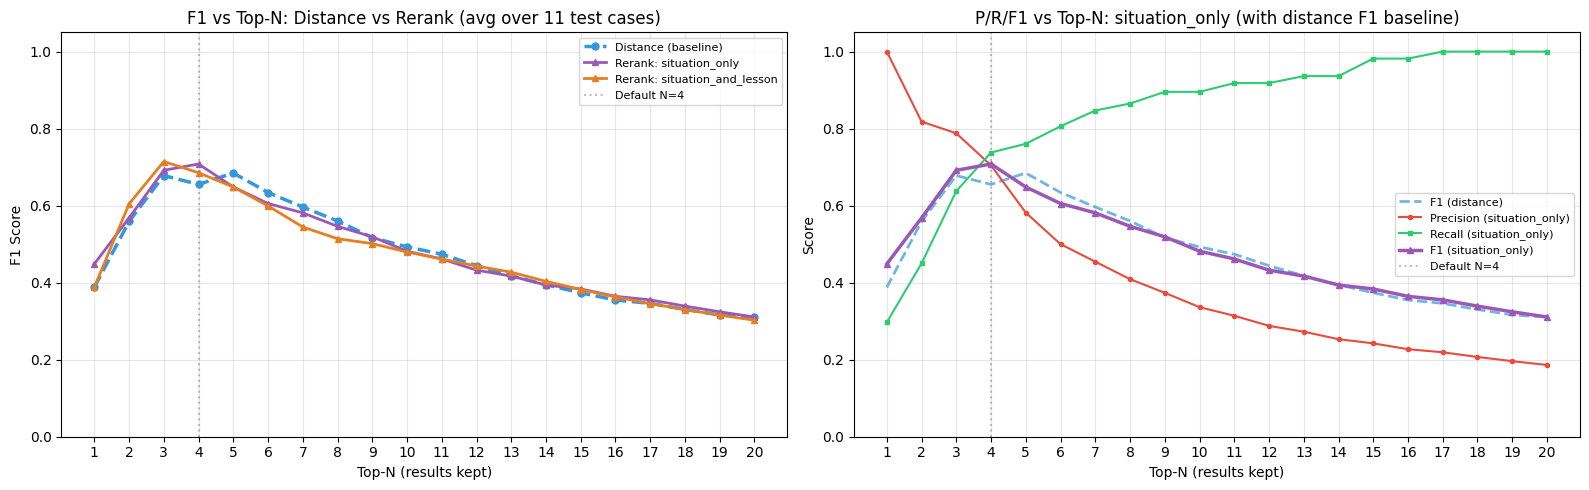

Saved: data/phase2/runs/run_20260214_123725/figures/rerank_topn_sweep.png


In [11]:
# Cell B — Top-N Sweep: Distance Baseline vs Rerank Strategies
import matplotlib.pyplot as plt
import numpy as np

FIGURES_DIR = RUN_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

num_test_cases = len(successful)
max_n = 20
n_values = list(range(1, max_n + 1))

# Distance baseline sweep
distance_experiments = [
    {
        "ground_truth_ids": set(data.get("ground_truth", {}).get("memory_ids", [])),
        "ranked_results": pool_and_deduplicate_by_distance(data.get("queries", [])),
    }
    for data in successful
]
distance_sweep = sweep_top_n(distance_experiments, n_values)
distance_f1_scores = [entry["f1"] for entry in distance_sweep]

# Per-strategy rerank sweeps
strategy_sweeps = {}
for key in strategy_names:
    rerank_experiments = [
        {
            "ground_truth_ids": set(data.get("ground_truth", {}).get("memory_ids", [])),
            "ranked_results": get_reranked_results(data, key),
        }
        for data in successful
    ]
    strategy_sweeps[key] = sweep_top_n(rerank_experiments, n_values)

# Print table
print(f"Top-N Sweep: Distance vs Rerank (averaged over {num_test_cases} test cases)\n")
header = f"{'N':>4} {'Dist F1':>8}"
for key in strategy_names:
    header += f" {key[:16] + ' F1':>18} {'Delta':>7}"
print(header)
print("-" * (14 + 27 * len(strategy_names)))
for top_n in [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]:
    if top_n <= max_n:
        index = top_n - 1
        row = f"{top_n:>4} {distance_f1_scores[index]:>8.3f}"
        for key in strategy_names:
            strategy_f1 = strategy_sweeps[key][index]["f1"]
            delta = strategy_f1 - distance_f1_scores[index]
            row += f" {strategy_f1:>18.3f} {delta:>+7.3f}"
        print(row)

# --- Plots ---
colors_rerank = ["#9b59b6", "#e67e22", "#2ecc71", "#e74c3c"]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: F1 comparison — distance baseline + all strategies
ax = axes[0]
ax.plot(
    n_values,
    distance_f1_scores,
    label="Distance (baseline)",
    color="#3498db",
    linewidth=2.5,
    marker="o",
    markersize=5,
    linestyle="--",
)
for i, key in enumerate(strategy_names):
    strategy_f1_values = [entry["f1"] for entry in strategy_sweeps[key]]
    ax.plot(
        n_values,
        strategy_f1_values,
        label=f"Rerank: {key}",
        color=colors_rerank[i % len(colors_rerank)],
        linewidth=2,
        marker="^",
        markersize=4,
    )
ax.axvline(
    x=ANALYSIS_TOP_N, color="gray", linestyle=":", alpha=0.5, label=f"Default N={ANALYSIS_TOP_N}"
)
ax.set_xlabel("Top-N (results kept)")
ax.set_ylabel("F1 Score")
ax.set_title(f"F1 vs Top-N: Distance vs Rerank (avg over {num_test_cases} test cases)")
ax.set_xticks(n_values)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Right: P/R/F1 detail for best strategy + distance baseline
best_strategy = max(strategy_names, key=lambda k: strategy_sweeps[k][ANALYSIS_TOP_N - 1]["f1"])
best_sweep = strategy_sweeps[best_strategy]
best_precisions = [entry["precision"] for entry in best_sweep]
best_recalls = [entry["recall"] for entry in best_sweep]
best_f1_values = [entry["f1"] for entry in best_sweep]

ax = axes[1]
ax.plot(
    n_values,
    distance_f1_scores,
    label="F1 (distance)",
    color="#3498db",
    linewidth=2,
    linestyle="--",
    alpha=0.7,
)
ax.plot(
    n_values,
    best_precisions,
    label=f"Precision ({best_strategy})",
    color="#e74c3c",
    linewidth=1.5,
    marker="o",
    markersize=3,
)
ax.plot(
    n_values,
    best_recalls,
    label=f"Recall ({best_strategy})",
    color="#2ecc71",
    linewidth=1.5,
    marker="s",
    markersize=3,
)
ax.plot(
    n_values,
    best_f1_values,
    label=f"F1 ({best_strategy})",
    color="#9b59b6",
    linewidth=2.5,
    marker="^",
    markersize=4,
)
ax.axvline(
    x=ANALYSIS_TOP_N, color="gray", linestyle=":", alpha=0.5, label=f"Default N={ANALYSIS_TOP_N}"
)
ax.set_xlabel("Top-N (results kept)")
ax.set_ylabel("Score")
ax.set_title(f"P/R/F1 vs Top-N: {best_strategy} (with distance F1 baseline)")
ax.set_xticks(n_values)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / "rerank_topn_sweep.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_topn_sweep.png'}")

[situation_only] GT rerank scores:     n= 41, min=0.0084, max=1.0000, mean=0.5496, median=0.7424
[situation_only] Non-GT rerank scores: n=365, min=0.0000, max=0.9897, mean=0.0240, median=0.0043
[situation_only] Mean separation: 0.5256 (moderate)
[situation_only] Per-test-case GT counts: [3, 5, 4, 2, 2, 3, 5, 4, 4, 5, 4] (total unique memories: 41)
[situation_only] Per-test-case Non-GT counts: [33, 29, 35, 36, 34, 35, 32, 33, 34, 32, 32] (total unique memories: 365)

[situation_and_lesson] GT rerank scores:     n= 41, min=0.0127, max=0.9999, mean=0.6648, median=0.8458
[situation_and_lesson] Non-GT rerank scores: n=365, min=0.0000, max=0.9971, mean=0.0511, median=0.0132
[situation_and_lesson] Mean separation: 0.6137 (moderate)
[situation_and_lesson] Per-test-case GT counts: [3, 5, 4, 2, 2, 3, 5, 4, 4, 5, 4] (total unique memories: 41)
[situation_and_lesson] Per-test-case Non-GT counts: [33, 29, 35, 36, 34, 35, 32, 33, 34, 32, 32] (total unique memories: 365)



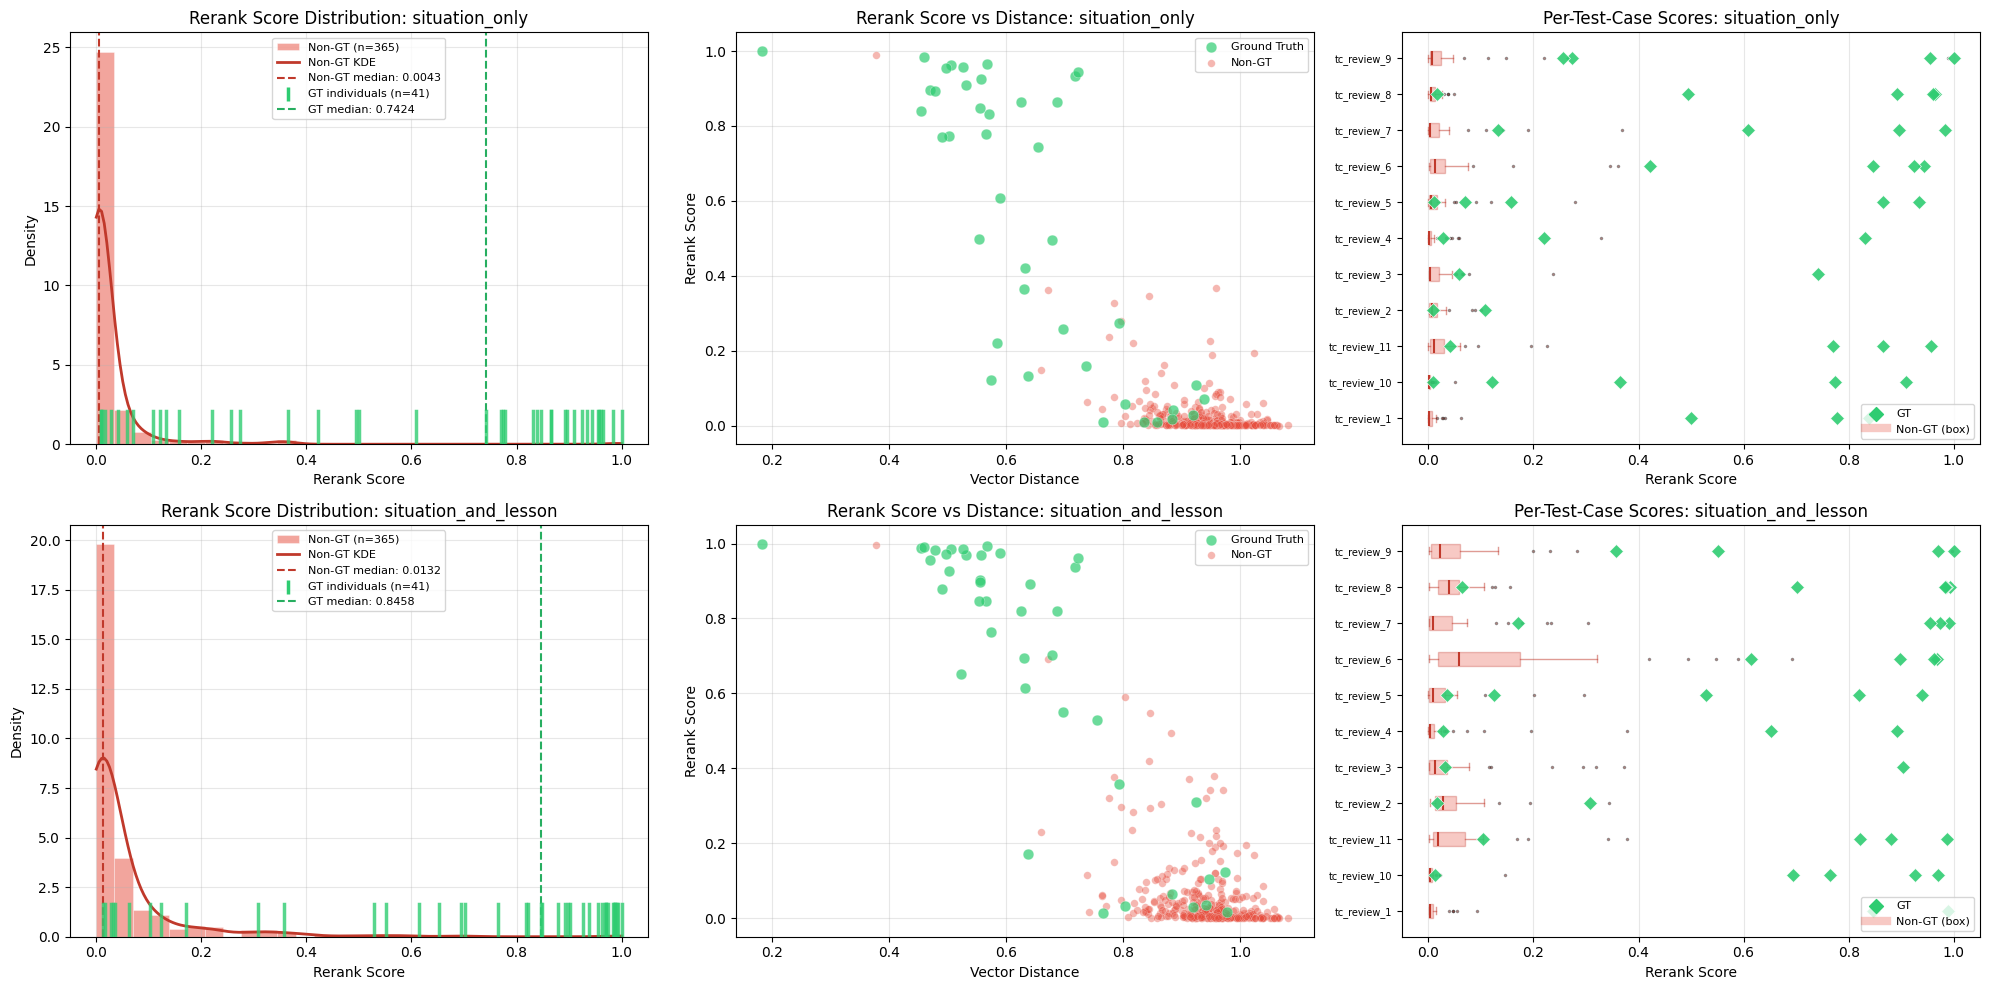

Saved: data/phase2/runs/run_20260214_123725/figures/rerank_score_distribution.png


In [12]:
# Cell C — Rerank Score Distribution (Per Strategy)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

n_strategies = len(strategy_names)
fig, axes = plt.subplots(n_strategies, 3, figsize=(20, 5 * n_strategies), squeeze=False)

for row, key in enumerate(strategy_names):
    gt_scores, non_gt_scores = [], []
    gt_distances, non_gt_distances = [], []
    per_test_case_gt_scores = {}
    per_test_case_non_gt_scores = {}

    for data in successful:
        test_case_id = data.get("test_case_id", "?")
        test_case_label = test_case_id[:20]
        reranked = get_reranked_results(data, key)
        tc_gt, tc_non_gt = [], []
        for result in reranked:
            if result.get("is_ground_truth"):
                gt_scores.append(result["rerank_score"])
                gt_distances.append(result["distance"])
                tc_gt.append(result["rerank_score"])
            else:
                non_gt_scores.append(result["rerank_score"])
                non_gt_distances.append(result["distance"])
                tc_non_gt.append(result["rerank_score"])
        if tc_gt or tc_non_gt:
            per_test_case_gt_scores[test_case_label] = tc_gt
            per_test_case_non_gt_scores[test_case_label] = tc_non_gt

    gt_arr = np.array(gt_scores)
    non_gt_arr = np.array(non_gt_scores)

    # --- Column 1: Density histogram (non-GT) + KDE overlay + GT strip markers ---
    ax = axes[row][0]
    all_scores = (
        np.concatenate([gt_arr, non_gt_arr])
        if len(gt_arr) and len(non_gt_arr)
        else (gt_arr if len(gt_arr) else non_gt_arr)
    )
    score_min, score_max = all_scores.min(), all_scores.max()
    bins = np.linspace(score_min, score_max, 30)

    if len(non_gt_arr):
        ax.hist(
            non_gt_arr,
            bins=bins,
            alpha=0.5,
            density=True,
            label=f"Non-GT (n={len(non_gt_arr)})",
            color="#e74c3c",
            edgecolor="white",
            linewidth=0.5,
        )
        # KDE overlay for non-GT
        if len(non_gt_arr) > 3:
            kde = gaussian_kde(non_gt_arr)
            x_kde = np.linspace(score_min, score_max, 200)
            ax.plot(x_kde, kde(x_kde), color="#c0392b", linewidth=2, label="Non-GT KDE")
        ax.axvline(
            np.median(non_gt_arr),
            color="#c0392b",
            linestyle="--",
            linewidth=1.5,
            label=f"Non-GT median: {np.median(non_gt_arr):.4f}",
        )

    if len(gt_arr):
        # GT as rug/strip plot — individual vertical lines at bottom
        y_max = ax.get_ylim()[1]
        strip_height = y_max * 0.08
        for score in gt_arr:
            ax.plot(
                [score, score],
                [0, strip_height],
                color="#2ecc71",
                linewidth=2.5,
                alpha=0.8,
                zorder=5,
            )
        # Invisible scatter for legend entry
        ax.scatter(
            [],
            [],
            color="#2ecc71",
            marker="|",
            s=100,
            linewidth=2.5,
            label=f"GT individuals (n={len(gt_arr)})",
        )
        ax.axvline(
            np.median(gt_arr),
            color="#27ae60",
            linestyle="--",
            linewidth=1.5,
            label=f"GT median: {np.median(gt_arr):.4f}",
        )

    ax.set_xlabel("Rerank Score")
    ax.set_ylabel("Density")
    ax.set_title(f"Rerank Score Distribution: {key}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # --- Column 2: Rerank score vs distance scatter (unchanged) ---
    ax = axes[row][1]
    if gt_scores:
        ax.scatter(
            gt_distances,
            gt_scores,
            alpha=0.7,
            label="Ground Truth",
            color="#2ecc71",
            s=60,
            zorder=3,
            edgecolors="white",
            linewidth=0.3,
        )
    if non_gt_scores:
        ax.scatter(
            non_gt_distances,
            non_gt_scores,
            alpha=0.4,
            label="Non-GT",
            color="#e74c3c",
            s=30,
            zorder=2,
            edgecolors="white",
            linewidth=0.3,
        )
    ax.set_xlabel("Vector Distance")
    ax.set_ylabel("Rerank Score")
    ax.set_title(f"Rerank Score vs Distance: {key}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # --- Column 3: Per-test-case box/strip comparison ---
    ax = axes[row][2]
    test_case_labels = sorted(per_test_case_gt_scores.keys() | per_test_case_non_gt_scores.keys())
    y_positions = list(range(len(test_case_labels)))

    for y_pos, label in enumerate(test_case_labels):
        tc_gt = per_test_case_gt_scores.get(label, [])
        tc_non_gt = per_test_case_non_gt_scores.get(label, [])

        # Non-GT as box plot
        if tc_non_gt:
            box = ax.boxplot(
                [tc_non_gt],
                positions=[y_pos],
                vert=False,
                widths=0.4,
                patch_artist=True,
                boxprops=dict(facecolor="#e74c3c", alpha=0.3, edgecolor="#c0392b"),
                medianprops=dict(color="#c0392b", linewidth=1.5),
                whiskerprops=dict(color="#c0392b", alpha=0.5),
                capprops=dict(color="#c0392b", alpha=0.5),
                flierprops=dict(marker=".", markerfacecolor="#e74c3c", markersize=3, alpha=0.4),
                manage_ticks=False,
            )

        # GT as individual strip markers
        if tc_gt:
            ax.scatter(
                tc_gt,
                [y_pos] * len(tc_gt),
                color="#2ecc71",
                marker="D",
                s=50,
                zorder=5,
                edgecolors="white",
                linewidth=0.5,
                alpha=0.9,
            )

    ax.set_yticks(y_positions)
    ax.set_yticklabels(test_case_labels, fontsize=7)
    ax.set_xlabel("Rerank Score")
    ax.set_title(f"Per-Test-Case Scores: {key}")
    ax.grid(True, alpha=0.3, axis="x")
    # Legend
    ax.scatter([], [], color="#2ecc71", marker="D", s=50, label="GT")
    ax.plot([], [], color="#e74c3c", linewidth=6, alpha=0.3, label="Non-GT (box)")
    ax.legend(fontsize=8, loc="lower right")

    # --- Statistics ---
    if len(gt_arr):
        print(
            f"[{key}] GT rerank scores:     n={len(gt_arr):>3}, min={gt_arr.min():.4f}, max={gt_arr.max():.4f}, mean={gt_arr.mean():.4f}, median={np.median(gt_arr):.4f}"
        )
    if len(non_gt_arr):
        print(
            f"[{key}] Non-GT rerank scores: n={len(non_gt_arr):>3}, min={non_gt_arr.min():.4f}, max={non_gt_arr.max():.4f}, mean={non_gt_arr.mean():.4f}, median={np.median(non_gt_arr):.4f}"
        )
    if len(gt_arr) and len(non_gt_arr):
        separation = gt_arr.mean() - non_gt_arr.mean()
        print(
            f"[{key}] Mean separation: {separation:.4f} ({'good' if separation > 1.0 else 'moderate' if separation > 0.5 else 'weak'})"
        )
    # Per-test-case counts
    gt_per_tc = [len(per_test_case_gt_scores.get(label, [])) for label in test_case_labels]
    non_gt_per_tc = [len(per_test_case_non_gt_scores.get(label, [])) for label in test_case_labels]
    print(f"[{key}] Per-test-case GT counts: {gt_per_tc} (total unique memories: {len(gt_arr)})")
    print(
        f"[{key}] Per-test-case Non-GT counts: {non_gt_per_tc} (total unique memories: {len(non_gt_arr)})"
    )
    print()

plt.tight_layout()
fig.savefig(FIGURES_DIR / "rerank_score_distribution.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_score_distribution.png'}")

OPTIMAL THRESHOLDS PER STRATEGY
  situation_only:                threshold=0.1000  F1=0.722  P=0.722  R=0.783  MRR=1.000
  situation_and_lesson:          threshold=0.4950  F1=0.744  P=0.847  R=0.692  MRR=0.909

Best strategy: situation_and_lesson


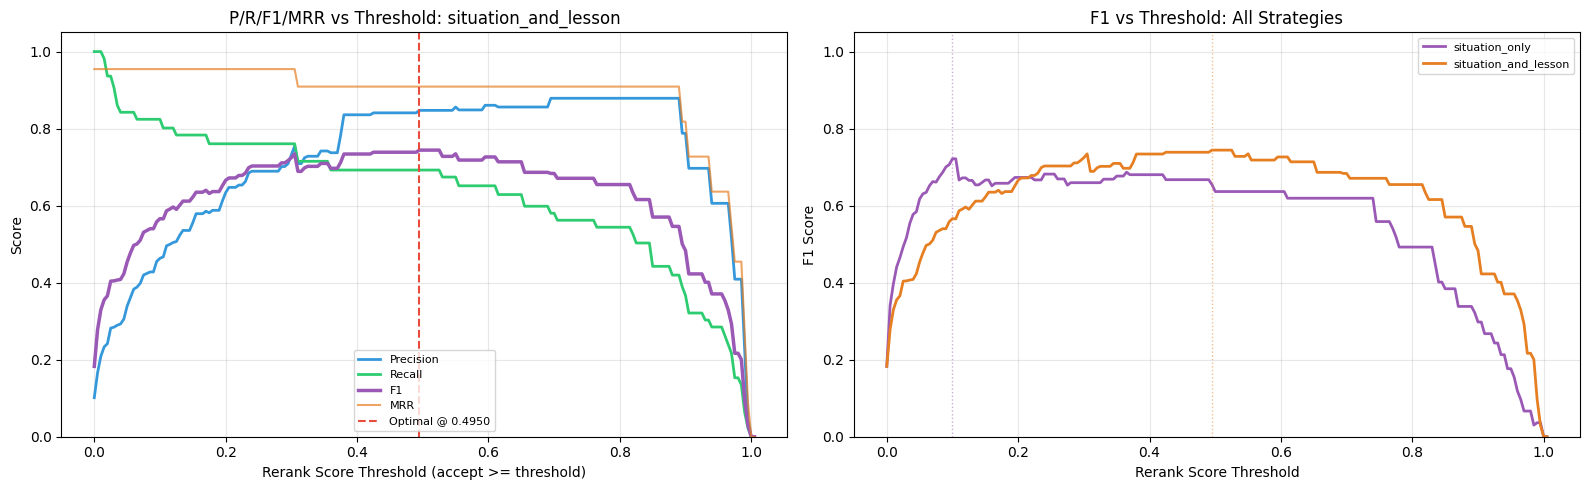

Saved: data/phase2/runs/run_20260214_123725/figures/rerank_threshold_sweep.png

Threshold table: situation_and_lesson (macro-averaged over 11 test cases)
 Threshold  Precision   Recall       F1      MRR  Avg Accepted  Avg GT Kept
---------------------------------------------------------------------------
    0.0010      0.101    1.000    0.183    0.955          33.6          3.7
    0.0050      0.166    1.000    0.278    0.955          25.1          3.7
    0.0100      0.209    1.000    0.330    0.955          21.5          3.7
    0.0200      0.242    0.936    0.366    0.955          17.7          3.5
    0.0300      0.284    0.906    0.405    0.955          14.6          3.5
    0.0500      0.339    0.842    0.454    0.955          11.6          3.3
    0.0800      0.424    0.824    0.535    0.955           8.5          3.2
    0.1000      0.463    0.824    0.566    0.955           7.8          3.2
    0.1500      0.556    0.783    0.622    0.955           6.0          3.0
    0.2000

In [13]:
# Cell D — Rerank Score Threshold Sweep (MAIN DELIVERABLE)
import matplotlib.pyplot as plt
import numpy as np

# Build per-strategy experiment lists for sweep
experiments_by_strategy = {}
for key in strategy_names:
    experiment_results = []
    for data in successful:
        ground_truth_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
        reranked = get_reranked_results(data, key)
        experiment_results.append(
            {
                "test_case_id": data["test_case_id"],
                "ground_truth_ids": ground_truth_ids,
                "ranked_results": reranked,
                "reranked": reranked,
            }
        )
    experiments_by_strategy[key] = experiment_results

# Determine sweep range from data
all_max_scores = []
for key in strategy_names:
    for experiment_result in experiments_by_strategy[key]:
        if experiment_result["ranked_results"]:
            all_max_scores.append(
                max(result["rerank_score"] for result in experiment_result["ranked_results"])
            )
global_max = max(all_max_scores) if all_max_scores else 1.0
sweep_thresholds = list(np.arange(0.0, global_max + 0.01, 0.005))

# Sweep thresholds per strategy using centralized metrics
strategy_sweep_results = {}
for key in strategy_names:
    sweep_results = sweep_threshold(
        experiments_by_strategy[key],
        sweep_thresholds,
        score_field="rerank_score",
        higher_is_better=True,
    )
    optimal = find_optimal_threshold(sweep_results, metric="f1")
    strategy_sweep_results[key] = {
        "sweep": sweep_results,
        "best_f1_index": optimal["index"],
        "best_threshold": optimal["threshold"],
    }

# --- Print optimal thresholds ---
print("OPTIMAL THRESHOLDS PER STRATEGY")
best_overall_strategy = None
best_overall_f1 = -1
for key in strategy_names:
    sweep_data = strategy_sweep_results[key]
    best_entry = sweep_data["sweep"][sweep_data["best_f1_index"]]
    print(
        f"  {key + ':':30} threshold={sweep_data['best_threshold']:.4f}  F1={best_entry['f1']:.3f}  P={best_entry['precision']:.3f}  R={best_entry['recall']:.3f}  MRR={best_entry['mrr']:.3f}"
    )
    if best_entry["f1"] > best_overall_f1:
        best_overall_f1 = best_entry["f1"]
        best_overall_strategy = key

print(f"\nBest strategy: {best_overall_strategy}")

# --- Plots ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: P/R/F1/MRR vs threshold for best strategy
best_sweep = strategy_sweep_results[best_overall_strategy]["sweep"]
best_precisions = [entry["precision"] for entry in best_sweep]
best_recalls = [entry["recall"] for entry in best_sweep]
best_f1_values = [entry["f1"] for entry in best_sweep]
best_mrr_values = [entry["mrr"] for entry in best_sweep]
best_threshold = strategy_sweep_results[best_overall_strategy]["best_threshold"]

ax = axes[0]
ax.plot(sweep_thresholds, best_precisions, label="Precision", color="#3498db", linewidth=2)
ax.plot(sweep_thresholds, best_recalls, label="Recall", color="#2ecc71", linewidth=2)
ax.plot(sweep_thresholds, best_f1_values, label="F1", color="#9b59b6", linewidth=2.5)
ax.plot(sweep_thresholds, best_mrr_values, label="MRR", color="#e67e22", linewidth=1.5, alpha=0.7)
ax.axvline(
    best_threshold,
    color="#e74c3c",
    linestyle="--",
    linewidth=1.5,
    label=f"Optimal @ {best_threshold:.4f}",
)
ax.set_xlabel("Rerank Score Threshold (accept >= threshold)")
ax.set_ylabel("Score")
ax.set_title(f"P/R/F1/MRR vs Threshold: {best_overall_strategy}")
ax.legend(fontsize=8)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

# Right: F1 vs threshold for ALL strategies
ax = axes[1]
colors_strategy = ["#9b59b6", "#e67e22", "#2ecc71", "#e74c3c"]
for i, key in enumerate(strategy_names):
    strategy_f1_values = [entry["f1"] for entry in strategy_sweep_results[key]["sweep"]]
    ax.plot(
        sweep_thresholds,
        strategy_f1_values,
        label=key,
        color=colors_strategy[i % len(colors_strategy)],
        linewidth=2,
    )
    ax.axvline(
        strategy_sweep_results[key]["best_threshold"],
        color=colors_strategy[i % len(colors_strategy)],
        linestyle=":",
        alpha=0.5,
        linewidth=1,
    )
ax.set_xlabel("Rerank Score Threshold")
ax.set_ylabel("F1 Score")
ax.set_title("F1 vs Threshold: All Strategies")
ax.legend(fontsize=8)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / "rerank_threshold_sweep.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_threshold_sweep.png'}")

# --- Threshold table for best strategy ---
print(
    f"\nThreshold table: {best_overall_strategy} (macro-averaged over {len(successful)} test cases)"
)
print(
    f"{'Threshold':>10} {'Precision':>10} {'Recall':>8} {'F1':>8} {'MRR':>8} {'Avg Accepted':>13} {'Avg GT Kept':>12}"
)
print("-" * 75)

table_thresholds = sorted(
    set(
        [
            0.001,
            0.005,
            0.01,
            0.02,
            0.03,
            0.05,
            0.08,
            0.10,
            0.15,
            0.20,
            0.30,
            0.50,
            round(best_threshold, 4),
        ]
    )
)
experiment_results = experiments_by_strategy[best_overall_strategy]
for threshold in table_thresholds:
    if threshold > global_max + 0.01:
        continue
    # Find closest sweep index
    index = min(
        range(len(sweep_thresholds)), key=lambda idx: abs(sweep_thresholds[idx] - threshold)
    )
    sweep_entry = strategy_sweep_results[best_overall_strategy]["sweep"][index]
    avg_accepted = np.mean(
        [
            len(
                [
                    result
                    for result in experiment_result["reranked"]
                    if result["rerank_score"] >= threshold
                ]
            )
            for experiment_result in experiment_results
        ]
    )
    avg_ground_truth_kept = np.mean(
        [
            len(
                {
                    result["id"]
                    for result in experiment_result["reranked"]
                    if result["rerank_score"] >= threshold
                }
                & experiment_result["ground_truth_ids"]
            )
            for experiment_result in experiment_results
        ]
    )
    marker = " <-- optimal" if abs(threshold - best_threshold) < 0.003 else ""
    print(
        f"{threshold:>10.4f} {sweep_entry['precision']:>10.3f} {sweep_entry['recall']:>8.3f} {sweep_entry['f1']:>8.3f} {sweep_entry['mrr']:>8.3f} {avg_accepted:>13.1f} {avg_ground_truth_kept:>12.1f}{marker}"
    )

In [18]:
# Cell E — Per-Test-Case Impact at Optimal Threshold
import numpy as np

from memory_retrieval.experiments.metrics import (
    compute_metrics_at_threshold,
    compute_metrics_at_top_n,
)

top_n = ANALYSIS_TOP_N
key = best_overall_strategy
best_threshold = strategy_sweep_results[key]["best_threshold"]
experiment_results = experiments_by_strategy[key]

print("Per-test-case comparison at best strategy's optimal threshold")
print(f"  Strategy: {key}")
print(f"  Threshold: score >= {best_threshold:.4f}")
print(f"  Distance baseline: top-{top_n} by distance")
print()

print(
    f"{'Test Case':<20} {'Dist F1':>8} {'Thr F1':>8} {'Delta':>8} {'Dist P':>7} {'Thr P':>7} {'Dist R':>7} {'Thr R':>7} {'D Acc':>6} {'T Acc':>6} {'GT':>4}"
)
print("-" * 105)

distance_f1_scores, threshold_f1_scores = [], []

for data, experiment_result in zip(successful, experiment_results):
    test_case_id = data["test_case_id"]
    ground_truth_ids = experiment_result["ground_truth_ids"]
    ground_truth_count = len(ground_truth_ids)

    # Distance baseline: top-N
    pooled = pool_and_deduplicate_by_distance(data.get("queries", []))
    distance_metrics = compute_metrics_at_top_n(pooled, ground_truth_ids, top_n)

    # Threshold-based
    threshold_metrics = compute_metrics_at_threshold(
        experiment_result["reranked"],
        ground_truth_ids,
        best_threshold,
        score_field="rerank_score",
        higher_is_better=True,
    )

    delta = threshold_metrics["f1"] - distance_metrics["f1"]
    marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="
    print(
        f"{test_case_id:<20} {distance_metrics['f1']:>8.3f} {threshold_metrics['f1']:>8.3f} {delta:>+7.3f}{marker} {distance_metrics['precision']:>7.1%} {threshold_metrics['precision']:>7.1%} {distance_metrics['recall']:>7.1%} {threshold_metrics['recall']:>7.1%} {len(distance_metrics['retrieved_ids']):>6} {threshold_metrics['accepted_count']:>6} {ground_truth_count:>4}"
    )

    # Show missed GT with their rerank scores
    missed = ground_truth_ids - threshold_metrics["retrieved_ids"]
    if missed:
        for memory_id in sorted(missed):
            score = next(
                (
                    result["rerank_score"]
                    for result in experiment_result["reranked"]
                    if result["id"] == memory_id
                ),
                None,
            )
            if score is not None:
                print(
                    f"  {'':20} Missed: {memory_id}  score={score:.4f} (below threshold {best_threshold:.4f})"
                )
            else:
                print(f"  {'':20} Missed: {memory_id}  NOT IN CANDIDATE POOL (query miss)")

    distance_f1_scores.append(distance_metrics["f1"])
    threshold_f1_scores.append(threshold_metrics["f1"])

avg_distance_f1 = np.mean(distance_f1_scores)
avg_threshold_f1 = np.mean(threshold_f1_scores)
delta = avg_threshold_f1 - avg_distance_f1
print("-" * 105)
print(
    f"{'AVERAGE':<20} {avg_distance_f1:>8.3f} {avg_threshold_f1:>8.3f} {delta:>+7.3f}{'+' if delta > 0.001 else '-' if delta < -0.001 else '='}"
)

improved = sum(
    1
    for dist_f1, thr_f1 in zip(distance_f1_scores, threshold_f1_scores)
    if thr_f1 > dist_f1 + 0.001
)
same = sum(
    1
    for dist_f1, thr_f1 in zip(distance_f1_scores, threshold_f1_scores)
    if abs(thr_f1 - dist_f1) <= 0.001
)
worse = sum(
    1
    for dist_f1, thr_f1 in zip(distance_f1_scores, threshold_f1_scores)
    if thr_f1 < dist_f1 - 0.001
)
print(
    f"\nThreshold helped: {improved}/{len(successful)} | Same: {same}/{len(successful)} | Hurt: {worse}/{len(successful)}"
)

Per-test-case comparison at best strategy's optimal threshold
  Strategy: situation_and_lesson
  Threshold: score >= 0.4950
  Distance baseline: top-4 by distance

Test Case             Dist F1   Thr F1    Delta  Dist P   Thr P  Dist R   Thr R  D Acc  T Acc   GT
---------------------------------------------------------------------------------------------------------
tc_review_10            0.889    0.889  +0.000=  100.0%  100.0%   80.0%   80.0%      4      4    5
                       Missed: mem_4b597e375319  score=0.0127 (below threshold 0.4950)
tc_review_11            0.750    0.857  +0.107+   75.0%  100.0%   75.0%   75.0%      4      3    4
                       Missed: mem_909fb253d425  score=0.1030 (below threshold 0.4950)
tc_review_1             0.857    1.000  +0.143+   75.0%  100.0%  100.0%  100.0%      4      3    3
tc_review_2             0.000    0.000  +0.000=    0.0%    0.0%    0.0%    0.0%      4      0    2
                       Missed: mem_0218b67ed9e3  score=0.0166

## Step 7 — Store Config Fingerprint & Run Summary

Stores a config fingerprint in `run.json` and generates a `run_summary.json` for
cross-run comparison. The fingerprint captures all pipeline parameters that affect results.
The summary precomputes metrics for fast comparison without loading full result files.

See `notebooks/comparison/cross_run_comparison.ipynb` for cross-run analysis.

In [ ]:
# Cell F — Store Config Fingerprint & Generate Run Summary
from memory_retrieval.experiments.comparison import (
    build_config_fingerprint,
    generate_run_summary,
)
from memory_retrieval.infra.runs import update_config_fingerprint

# Build fingerprint from this run's configuration
fingerprint = build_config_fingerprint(
    extraction_prompt_version=PROMPT_VERSION,
    embedding_model="mxbai-embed-large",
    search_backend="vector",
    search_limit=SEARCH_LIMIT,
    distance_threshold=DISTANCE_THRESHOLD,
    query_model=MODEL_EXPERIMENT,
    query_prompt_version=PROMPT_VERSION,
    reranker_model="BAAI/bge-reranker-v2-m3",
    rerank_text_strategies=list(RERANK_TEXT_STRATEGIES.keys()),
)

# Store in run.json
update_config_fingerprint(RUN_DIR, fingerprint)
print(f"Config fingerprint stored: {fingerprint['fingerprint_hash']}")
for key, value in fingerprint.items():
    if key != "fingerprint_hash":
        print(f"  {key}: {value}")

# Generate run summary
summary = generate_run_summary(RUN_DIR, strategies=list(RERANK_TEXT_STRATEGIES.keys()))
macro = summary.get("macro_averaged", {})
print(f"\nRun summary generated: {RUN_DIR / 'run_summary.json'}")
print(f"  Test cases: {summary['num_test_cases']}")

# Pre-rerank: overfetched (raw) metrics
pre_rerank = macro.get("pre_rerank", {})
overfetched = pre_rerank.get("overfetched", {})
print(
    f"\n  Pre-rerank (overfetched, raw): F1={overfetched.get('f1', 0):.3f} "
    f"P={overfetched.get('precision', 0):.3f} R={overfetched.get('recall', 0):.3f}"
)

# Pre-rerank: at optimal distance threshold
at_optimal_distance = pre_rerank.get("at_optimal_distance_threshold", {})
if at_optimal_distance:
    print(
        f"  Pre-rerank (optimal distance threshold): F1={at_optimal_distance.get('f1', 0):.3f} "
        f"P={at_optimal_distance.get('precision', 0):.3f} R={at_optimal_distance.get('recall', 0):.3f} "
        f"@ threshold={at_optimal_distance.get('optimal_threshold', 0):.4f}"
    )

# Pre-rerank: at optimal top-N
at_optimal_top_n = pre_rerank.get("at_optimal_top_n", {})
if at_optimal_top_n:
    print(
        f"  Pre-rerank (optimal top-N): F1={at_optimal_top_n.get('f1', 0):.3f} "
        f"P={at_optimal_top_n.get('precision', 0):.3f} R={at_optimal_top_n.get('recall', 0):.3f} "
        f"@ N={at_optimal_top_n.get('optimal_n', 0)}"
    )

# Post-rerank per strategy
post_rerank = macro.get("post_rerank", {})
for strategy_name, strategy_data in post_rerank.items():
    at_threshold = strategy_data.get("at_optimal_threshold", {})
    at_top_n = strategy_data.get("at_optimal_top_n", {})
    print(f"\n  Post-rerank ({strategy_name}):")
    if at_threshold:
        print(
            f"    At optimal threshold: F1={at_threshold.get('f1', 0):.3f} "
            f"P={at_threshold.get('precision', 0):.3f} R={at_threshold.get('recall', 0):.3f} "
            f"@ threshold={at_threshold.get('optimal_threshold', 0):.4f}"
        )
    if at_top_n:
        print(
            f"    At optimal top-N:     F1={at_top_n.get('f1', 0):.3f} "
            f"P={at_top_n.get('precision', 0):.3f} R={at_top_n.get('recall', 0):.3f} "
            f"@ N={at_top_n.get('optimal_n', 0)}"
        )